In [ ]:
!unzip "/content/drive/My Drive/thai-mnist-classification.zip" -d "/content/dataset"

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5f9a0d1e-c95a-44eb-84e1-ada90cb3f19e)


Note:
create folder 
1. dataset
2. cropped data
3. test cropped data

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.read_csv("/content/dataset/mnist.train.map.csv", dtype=str)
train_df.head()

,id,category
0,75606737-d17d-43eb-86e6-6735b6f45a52.png,8
1,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,1
2,c40b7fc4-07f1-4c78-abac-121bde38e267.png,0
3,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,b8fd3385-9403-48a4-9d9e-74bde635e688.png,9


# Image preparation for training

In [ ]:
from skimage.morphology import convex_hull_image
from skimage.util import invert
from skimage import data, img_as_float
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img
from keras.preprocessing import image

In [ ]:
class getdata():
    def __init__(self,data_path,label_path):
      self.dataPath = data_path
      self.labelPath = label_path
      self.label_df = pd.read_csv(label_path)
      self.dataFile = self.label_df['id'].values
      self.label = self.label_df['category'].values
      self.n_index = len(self.dataFile)
        
    
    def get1img(self,img_index,mode='rgb',label = False):
      img = cv2.imread( os.path.join(self.dataPath,self.label_df.iloc[img_index]['id']) )
      if mode == 'rgb':
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      elif mode == 'gray':
          img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      if label:
          return img,self.label_df.iloc[img_index]['category']
      return img


In [ ]:
gdt = getdata("/content/dataset/train", "/content/dataset/mnist.train.map.csv")

In [ ]:
plt.gray()

<Figure size 432x288 with 0 Axes>

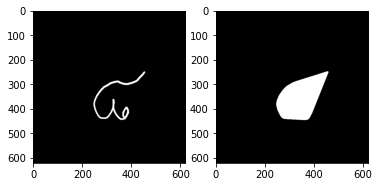

In [ ]:
import cv2
import os 
temp_img = invert(gdt.get1img(0, 'gray'))
fig, [ax1,ax2] = plt.subplots(1, 2)
ax1.imshow(temp_img)
cvh =  convex_hull_image(temp_img)
ax2.imshow(cvh)

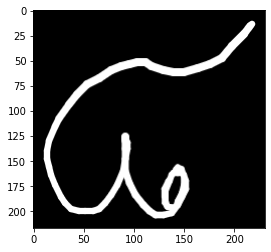

In [ ]:
# Crop images
def convex_crop(img,pad=20):
    convex = convex_hull_image(img)
    r,c = np.where(convex)
    while (min(r)-pad < 0) or (max(r)+pad > img.shape[0]) or (min(c)-pad < 0) or (max(c)+pad > img.shape[1]):
        pad = pad - 1
    return img[min(r)-pad:max(r)+pad,min(c)-pad:max(c)+pad]

crop_img = convex_crop(temp_img,pad=10)
plt.imshow(crop_img)

In [ ]:
img_h = 64
img_w = 64

In [ ]:
def convex_resize(img):
    img = invert(img)
    img = convex_crop(img,pad=20)
    img = cv2.resize(img,(img_h, img_w))
    return img

def thes_resize(img,thes=40):
    img = invert(img)
    img = convex_crop(img,pad=20)
    img = ((img > thes)*255).astype(np.uint8)
    if(min(img.shape) > 300):
        img = cv2.resize(img,(300,300))
        img = ((img > thes)*255).astype(np.uint8)
    if(min(img.shape) > 150):
        img = cv2.resize(img,(150,150))
        img = ((img > thes)*255).astype(np.uint8)
    img = cv2.resize(img,(80,80))
    img = ((img > thes)*255).astype(np.uint8)
    img = cv2.resize(img,(50,50))
    img = ((img > thes)*255).astype(np.uint8)
    img = cv2.resize(img,(img_h, img_w))
    img = ((img > thes)*255).astype(np.uint8)
    return img

Text(0.5, 1.0, 'Thresholding')

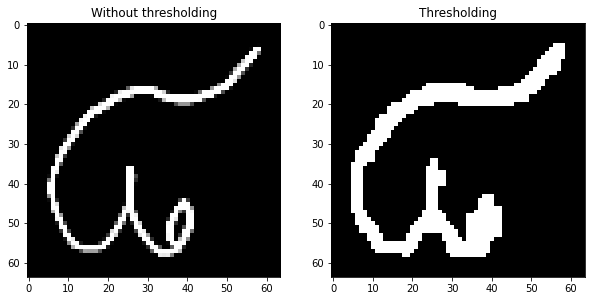

In [ ]:
temp_img = gdt.get1img(0, 'gray')
fig, [ax1,ax2] = plt.subplots(1, 2,figsize=(10,7))
ax1.imshow(convex_resize(temp_img))
ax1.set_title('Without thresholding')
ax2.imshow(thes_resize(temp_img))
ax2.set_title('Thresholding')

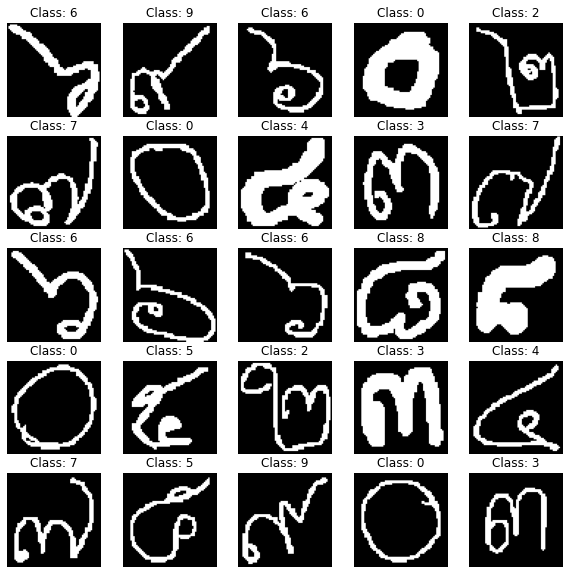

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        img_index = np.random.randint(0,gdt.n_index)
        ax[i][j].imshow(thes_resize(gdt.get1img(img_index,'gray')))
        ax[i][j].set_title('Class: '+str(gdt.label[img_index]))
        ax[i][j].set_axis_off()

In [ ]:
# import matplotlib.image as mpimg
# # img = mpimg.imread('../../doc/_static/stinkbug.png')

# for fig in train_df["id"]:
#     im1 = mpimg.imread("/content/dataset/train/"+fig)
#     # im1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # plt.imshow(img)
#     im2 = (thes_resize(im1))
#     plt.savefig('/content/image prepared dataset/'+'fig')
#     # im2.save(r"/content/image prepared dataset/"+fig )


In [ ]:
!pip install pypng

     |████████████████████████████████| 655kB 6.0MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67162 sha256=2fbdc5fb670ceceb874b2c8d92a75120dbf3a798e8c5cbf4ea7aeae338289c14
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [ ]:
X = []
import png
for i in range(gdt.n_index):
    X.append(thes_resize(gdt.get1img(i, 'gray')))
    png.from_array(X[i], 'L').save("/content/cropped data/" + gdt.dataFile[i])
    if (i+1) % 100 == 0:
        print(i)
# X = np.array(X)

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499
4599
4699
4799
4899
4999
5099
5199
5299
5399
5499
5599
5699
5799
5899
5999
6099
6199
6299
6399
6499
6599
6699
6799
6899
6999
7099
7199
7299
7399
7499
7599
7699
7799
7899
7999
8099
8199


# data generator

In [ ]:
# y = gdt.label
# X = X.reshape((-1, img_h, img_w, 1))
# X.shape,y.shape

In [ ]:
# import tensorflow as tf
# y_cat = tf.keras.utils.to_categorical(y)
# y_cat.shape

In [ ]:
# X.shape,y_cat.shape

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20, random_state=123)

In [ ]:
# # Normalized
# X_train = X_train / 255.
# X_test = X_test / 255.

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="/content/cropped data",
x_col="id",
y_col="category",
subset="training",
color_mode='grayscale',
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_h, img_w))

valid_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="/content/cropped data",
x_col="id",
y_col="category",
subset="validation",
color_mode='grayscale',
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_h, img_w))

Found 6604 validated image filenames belonging to 10 classes.
Found 1651 validated image filenames belonging to 10 classes.


In [ ]:
train_generator.image_shape

(64, 64, 1)

# Create Model and training

In [ ]:
# ResnetV2 
# ไม่ค่อยดี

# from tensorflow.keras.applications import InceptionResNetV2
# from tensorflow.keras import layers, Model
# from tensorflow.keras import optimizers

# ires  = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(75,75,3))
# for l in ires.layers[:]:
#   l.trainable  = False
# x = layers.Flatten()(ires.output)
# x = layers.Dense(10 , activation='softmax')(x)
# model = Model(ires.input, x)
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, Model 

vgg = VGG16(include_top=False, weights='imagenet')
for l in vgg.layers[:]:
  l.trainable  = False
# fit input
x_in = layers.Input(shape=(img_h, img_w, 1))
x = layers.Conv2D(3, 1)(x_in)
x = vgg(x)
# fit output
x = layers.Flatten()(x)
x = layers.Dense(10, activation='softmax')(x) 
model = Model(x_in, x)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         6         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 14,735,184
Trainable params: 20,496
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.0000001)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=128, validation_data=valid_generator, epochs=100)
# history = model.fit(X_train, y_train, batch_size=64,validation_data=(X_test, y_test), epochs=100, callbacks=[early_stop])

Epoch 1/100
207/207 [==============================] - 8s 37ms/step - loss: 0.7117 - accuracy: 0.8213 - val_loss: 0.3155 - val_accuracy: 0.9231
Epoch 2/100
207/207 [==============================] - 7s 33ms/step - loss: 0.2818 - accuracy: 0.9317 - val_loss: 0.2270 - val_accuracy: 0.9455
Epoch 3/100
207/207 [==============================] - 7s 34ms/step - loss: 0.2086 - accuracy: 0.9487 - val_loss: 0.1950 - val_accuracy: 0.9534
Epoch 4/100
207/207 [==============================] - 7s 34ms/step - loss: 0.1759 - accuracy: 0.9584 - val_loss: 0.1773 - val_accuracy: 0.9558
Epoch 5/100
207/207 [==============================] - 7s 34ms/step - loss: 0.1522 - accuracy: 0.9640 - val_loss: 0.1621 - val_accuracy: 0.9588
Epoch 6/100
207/207 [==============================] - 7s 34ms/step - loss: 0.1352 - accuracy: 0.9687 - val_loss: 0.1464 - val_accuracy: 0.9661
Epoch 7/100
207/207 [==============================] - 7s 34ms/step - loss: 0.1237 - accuracy: 0.9724 - val_loss: 0.1532 - val_accuracy:

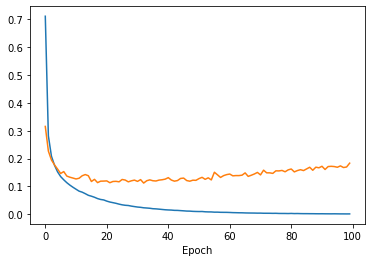

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.show()

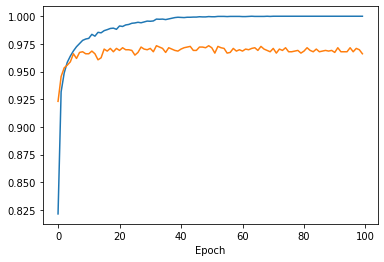

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.show()

# test predict with train.rule
(no need to run)

test predict with train.rule

In [ ]:
test_df = pd.read_csv('/content/dataset/train.rules.csv')
test_df.head()

,id,feature1,feature2,feature3,predict
0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4


In [ ]:
test_df = test_df.fillna("-1")
test_df.head()

,id,feature1,feature2,feature3,predict
0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,-1,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,-1,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4


In [ ]:
t_nan = test_df.loc[ test_df["feature1"] == "-1"]
t_nan.head()

,id,feature1,feature2,feature3,predict
0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,-1,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,-1,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,-1,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4


In [ ]:
test_df = test_df.drop(test_df[test_df.feature1 == "-1"].index)
test_df.head()

,id,feature1,feature2,feature3,predict
70,41e3b3a3-33b6-48b3-9003-f0ad5f8da4ad,945fb6be-2376-4216-b8bb-186a3a187b57.png,3d500cc8-8e06-4ca6-8564-048c51e59d32.png,e6f348df-7167-4943-b8e3-a5d25be4e2e9.png,9
75,e7e18d14-8973-4228-8a32-55c21ff4d594,4fdb13e9-e29e-43f1-908d-d19724ccb0b1.png,5fe39810-519b-467b-8e5a-8535560419bd.png,602d1db8-34a4-4d4d-aba2-d477682ebd8b.png,24
78,f7161b51-7cd5-471a-94df-2e553270ed24,4a7d1655-2b04-48cd-8db2-0d6050e2d7d7.png,a5174e78-6306-4768-b059-7c49ca622404.png,c591186c-d87b-4dcc-bf3d-f4323723718b.png,15
82,cb4d9f5a-84b6-48fc-958f-f17c406fb575,e288b3dc-de75-45b4-bfb6-ccabf4edabd8.png,a329c70f-edb3-4649-abf3-3008ccc9cac1.png,c7792959-67aa-42dc-896c-685aca94fbef.png,5
85,0bf0a2d6-60f5-443f-a7b2-80e4c89e4331,9c9cc1a3-74f7-4496-871e-8cd906a2e38d.png,7861c47c-de16-4886-a379-f92194467016.png,1a79da4b-0bbd-4a9e-8a6e-c93365a6e4f8.png,24


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_feature1=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/content/cropped data",
x_col="feature1",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

test_feature2=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/content/cropped data",
x_col="feature2",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

test_feature3=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="/content/cropped data",
x_col="feature3",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

Found 5271 validated image filenames.
Found 5271 validated image filenames.
Found 5271 validated image filenames.


In [ ]:
pred1=model.predict(test_feature1)
pred2=model.predict(test_feature2)
pred3=model.predict(test_feature3)

In [ ]:
predicted_class_indices1 = np.argmax(pred1, axis=1)
predicted_class_indices2 = np.argmax(pred2, axis=1)
predicted_class_indices3 = np.argmax(pred3, axis=1)

In [ ]:
predicted_class_indices3[0:10]

array([3, 6, 3, 5, 4, 1, 4, 5, 6, 6])

In [ ]:
test_df['feature1'] = predicted_class_indices1%99
test_df['feature2'] = predicted_class_indices2%99
test_df['feature3'] = predicted_class_indices3%99
test_df[500:3000]

,id,feature1,feature2,feature3,predict
679,001b72fa-8489-46e2-a182-1fe9a52c435e,1,3,0,3
680,03c8b82a-6077-430d-aab7-aa6381f51a70,0,6,5,30
681,344d90b2-6e4e-4529-ae74-af4e7674245a,9,0,3,0
682,4614da07-4fde-4b32-9c8c-3c17ac7d3546,0,2,9,18
683,71fb251c-ec41-441d-924e-98fa6bdb2447,0,9,8,72
...,...,...,...,...,...
3247,07b341fb-d6da-4834-b9fb-8f081a700e91,0,7,5,35
3248,7d4a924e-f543-46e2-8813-4df4810b9064,3,3,3,3
3249,892eb10b-57be-4397-92e7-c1f31ce31d56,4,7,3,54
3250,426ff32f-60e2-4833-aa63-ada5e9d5ccc4,5,4,9,4


แยก dataframe 11 ตางราง เป็น feature1 ที่ 0 ถึง 9 และ NaN 

In [ ]:
# test_df['predict'] = test_df['feature2'] * test_df['feature3']

In [ ]:
t_nan = test_df.loc[ test_df["feature1"] == "-1"]
t_nan.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,id,feature1,feature2,feature3,predict


In [ ]:
t0 = test_df.loc[ test_df['feature1'] == 0]
t1 = test_df.loc[ test_df['feature1'] == 1]
t2 = test_df.loc[ test_df['feature1'] == 2]
t3 = test_df.loc[ test_df['feature1'] == 3]
t4 = test_df.loc[ test_df['feature1'] == 4]
t5 = test_df.loc[ test_df['feature1'] == 5]
t6 = test_df.loc[ test_df['feature1'] == 6]
t7 = test_df.loc[ test_df['feature1'] == 7]
t8 = test_df.loc[ test_df['feature1'] == 8]
t9 = test_df.loc[ test_df['feature1'] == 9]
t9

# Predict submit

prepare data

In [ ]:
 import os
 arr = os.listdir('/content/dataset/test')
 print(arr)

['bbcd5140-22dd-4f18-92c2-0f3a6794288e.png', '98f0920e-47cc-437a-bf93-8de1b06e58aa.png', 'b16a8ca5-349c-4109-bfe6-c2f3d66bd226.png', '7d1433a0-cdda-4281-b836-fee52886d900.png', 'f8eb8937-f449-4a9c-83c8-4f255388903b.png', '5ff4725c-bf19-4816-941d-125e98676c2b.png', '9594f423-a4e6-4052-b674-011771326db9.png', 'ec40aa73-f6ab-45e9-a230-1da48578da12.png', '2a96c15b-46b0-433f-8adb-bf54d6e70ee4.png', 'b889fa9c-8cda-4a2b-b957-38fa4c98527f.png', '25e2a886-8e3e-4e6a-b2aa-3a5dcff91173.png', 'c34b1ad2-6764-42bd-8616-1bd4a20bd45d.png', '4524c780-6671-4d90-a8cc-784e975b4ab6.png', '5180dea3-d2ab-4719-bc79-3a24e2d22bed.png', '8db031d9-5c33-4c9b-9694-bc0236a35e74.png', '6518d2d8-21e8-455f-9d20-7ef37b855d6a.png', '5ef24bd1-4b0e-45e5-af88-2f9e6a3c5a02.png', 'ce7cf6f9-a730-44a8-b046-9edda26749b2.png', '615457b3-55f6-4996-9f97-cde67f2a766c.png', 'adaa4741-f6a5-4a80-b218-121536fa5e51.png', '94232151-7ff6-40dd-aeb7-f7134199c7ce.png', '83f2fc38-cbad-452d-b69b-51c4e611f0ba.png', 'd7ca7f59-a220-418b-96bf-4ab6e9

In [ ]:
testimg = pd.DataFrame(arr, columns=['id'])
testimg["category"] = -1
testimg.head()

,id,category
0,bbcd5140-22dd-4f18-92c2-0f3a6794288e.png,-1
1,98f0920e-47cc-437a-bf93-8de1b06e58aa.png,-1
2,b16a8ca5-349c-4109-bfe6-c2f3d66bd226.png,-1
3,7d1433a0-cdda-4281-b836-fee52886d900.png,-1
4,f8eb8937-f449-4a9c-83c8-4f255388903b.png,-1


In [ ]:
testimg.to_csv('test_img.csv', index=False)

In [ ]:
class getdata():
    def __init__(self,data_path,label_path):
      self.dataPath = data_path
      self.labelPath = label_path
      self.label_df = pd.read_csv(label_path)
      self.dataFile = self.label_df['id'].values
      self.label = self.label_df['category'].values
      self.n_index = len(self.dataFile)
        
    
    def get1img(self,img_index,mode='rgb',label = False):
      img = cv2.imread( os.path.join(self.dataPath,self.label_df.iloc[img_index]['id']) )
      if mode == 'rgb':
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      elif mode == 'gray':
          img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      if label:
          return img,self.label_df.iloc[img_index]['category']
      return img


In [ ]:
# ทำรูปในชัด แล้วไปเซฟไว้ใน test cropped data
gdt = getdata("/content/dataset/test", "/content/test_img.csv")

X = []
import png
for i in range(gdt.n_index):
    X.append(thes_resize(gdt.get1img(i, 'gray')))
    png.from_array(X[i], 'L').save("/content/test cropped data/" + gdt.dataFile[i])
    if (i+1) % 100 == 0:
        print(i)
# X = np.array(X)

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199


In [ ]:
submit_df=pd.read_csv("/content/dataset/test.rules.csv",dtype=str)
submit_df.head()

,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,NaN,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,NaN
3,baeeeb75-2845-4d33-a099-d0e32ec48078,NaN,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,NaN
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,NaN,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,NaN


In [ ]:
submit_df = submit_df.fillna("-1")
submit_df

,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,-1,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,-1
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,-1,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,-1
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,-1,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,-1
3,baeeeb75-2845-4d33-a099-d0e32ec48078,-1,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,-1
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,-1,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,-1
...,...,...,...,...,...
19995,517b1d08-e416-4950-880e-a06f4ba0e2ff,dfa408b2-0c5d-427d-a2c7-d88f1d34cac2.png,867b7956-8aaf-4f71-bc0a-a3082c9b28fd.png,eccfcdd3-05ed-4e44-bc8c-65087baf22e1.png,-1
19996,e1fd0fe1-ca87-4797-91c5-9147918ffb04,-1,c8969dd8-c966-49fe-af16-62057f64eaf3.png,5fd68ded-796b-4001-ac9d-c765f25e081f.png,-1
19997,0713dc83-0cd3-4a80-9081-02d24edf78c6,-1,05948632-01a1-4b4e-a988-bfdc192fc489.png,ef05172a-2127-4ae8-a716-0dfab4bd34b8.png,-1
19998,8f2826c2-57b7-4f22-af87-968c317cfd21,5ec32093-1be0-44d1-9681-caef50b6e266.png,eda9cc8c-b7b1-40ce-a0c1-a211e3aed3d4.png,a35b95c5-c6b3-43b3-94d7-166cdf6f1c15.png,-1


In [ ]:
submit_df.groupby('feature1').count()

,id,feature2,feature3,predict
feature1,,,,
-1,16948,16948,16948,16948
0027c93a-fb30-446c-b1b9-14d76191cccb.png,1,1,1,1
0089842a-a462-4f1b-9530-40af678fed1e.png,3,3,3,3
00b1d98c-a13d-492c-bc8f-3382a3f3e7d0.png,1,1,1,1
00d8260e-701a-4f45-876b-63906f24d9f7.png,1,1,1,1
...,...,...,...,...
ff18e565-8f89-4a09-afe4-b85ed7f9ef06.png,3,3,3,3
ff20271f-77ca-4624-aaa7-fe387bb2f8a7.png,2,2,2,2
ff7c65bf-cf43-45d9-9f72-a87a8bf56100.png,2,2,2,2


In [ ]:
submit_nan = submit_df.loc[ submit_df["feature1"] == "-1"]
submit_nan

,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,-1,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,-1
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,-1,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,-1
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,-1,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,-1
3,baeeeb75-2845-4d33-a099-d0e32ec48078,-1,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,-1
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,-1,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,-1
...,...,...,...,...,...
19992,58a7b16f-ac68-43c6-9478-d1db2df01c6d,-1,f7faad65-eb05-4c40-a54d-f745ba4e9af3.png,b5d11553-2e38-40b2-90ff-10e061344b66.png,-1
19994,c5ed1d3b-f2bd-4a46-ae02-1473104bc40d,-1,31977b33-58a9-4de3-917f-7ca68c0c31ab.png,6c6ccc11-9918-470a-908c-656908ab2542.png,-1
19996,e1fd0fe1-ca87-4797-91c5-9147918ffb04,-1,c8969dd8-c966-49fe-af16-62057f64eaf3.png,5fd68ded-796b-4001-ac9d-c765f25e081f.png,-1
19997,0713dc83-0cd3-4a80-9081-02d24edf78c6,-1,05948632-01a1-4b4e-a988-bfdc192fc489.png,ef05172a-2127-4ae8-a716-0dfab4bd34b8.png,-1


In [ ]:
submit_df = submit_df.drop(submit_df[submit_df.feature1 == "-1"].index)
submit_df

,id,feature1,feature2,feature3,predict
10318,748aed78-18c9-4d06-8d29-38d139c0ab64,231f0bfe-4a61-4d4c-be14-f017c5aa47a6.png,ccd0a9d1-8e9a-46a7-8a0e-1597d9b45436.png,ed10665a-a38c-400f-8287-b2e2ab665d1c.png,-1
10333,e4849f64-a990-4c10-8d3c-701b9d058b1e,a5946b1c-cc6b-4b41-932f-cfc12a19d034.png,056f9825-4f58-436e-93bb-127b190b74b6.png,b15a12f5-9ef2-493c-8ec8-1c0df7bbde7a.png,-1
10360,180b08fa-c141-4430-a134-614b162726d1,1b7236d0-be6b-4a19-b704-8647c5c2f376.png,25e2a886-8e3e-4e6a-b2aa-3a5dcff91173.png,c3f46259-eed7-40ac-84bd-ac45ac97f6dd.png,-1
10376,f4459397-2999-46ef-8f98-c8e312189211,efba533f-2274-45fe-af1b-f3d139e461be.png,83f9f307-addc-4f01-abb7-e7b31e00d8b6.png,30c139df-ea3a-43a4-9d66-82e35e187aa6.png,-1
10406,71637035-45dd-4f63-992f-19fc18b7d414,998b54ce-2cfa-43fc-b156-a42480ff9953.png,ce1452cb-595c-45a1-bd9b-24a350b7f849.png,8b54ae01-22b8-441c-b149-c52b68749f22.png,-1
...,...,...,...,...,...
19990,525a7f14-2a58-44c4-967f-57cee2eb8a79,171d39cc-8720-4125-a748-2bb9e49bb549.png,df2615a6-d33b-42c9-b55d-77966572ac5c.png,ebfc88d4-1fa7-4c82-82c9-5f8646a983ab.png,-1
19991,c4dd630c-e49c-47c6-afd3-2e7c155f283b,60becc71-da59-4fe2-82e7-4f5ff0e89e3b.png,e3c16763-09d1-411a-957f-de197c63a8f3.png,83df9bb0-606c-4ad7-b06c-a253b3e19560.png,-1
19993,7d70a1d8-6b42-4bbd-993b-5f0fed230134,1f3d3955-158f-4d2a-bde5-d110445fc117.png,67c8e554-65c7-4a7a-a096-408eb14e8654.png,94530394-3653-4f8f-8256-728ed54cf766.png,-1
19995,517b1d08-e416-4950-880e-a06f4ba0e2ff,dfa408b2-0c5d-427d-a2c7-d88f1d34cac2.png,867b7956-8aaf-4f71-bc0a-a3082c9b28fd.png,eccfcdd3-05ed-4e44-bc8c-65087baf22e1.png,-1


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_feature1=test_datagen.flow_from_dataframe(
dataframe=submit_df,
directory="/content/test cropped data",
x_col="feature1",
y_col=None,
color_mode='grayscale',
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_h,img_w))

test_feature2=test_datagen.flow_from_dataframe(
dataframe=submit_df,
directory="/content/test cropped data",
x_col="feature2",
y_col=None,
batch_size=32,
color_mode='grayscale',
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_h,img_w))

test_feature3=test_datagen.flow_from_dataframe(
dataframe=submit_df,
directory="/content/test cropped data",
x_col="feature3",
y_col=None,
color_mode='grayscale',
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_h,img_w))

Found 3052 validated image filenames.
Found 3052 validated image filenames.
Found 3052 validated image filenames.


In [ ]:
# for nan
# test_feature1_nan=test_datagen.flow_from_dataframe(
# dataframe=submit_nan,
# directory="/content/test cropped data",
# x_col="feature1",
# y_col=None,
# color_mode='grayscale',
# batch_size=32,
# seed=42,
# shuffle=False,
# class_mode=None,
# target_size=(img_h,img_w))

test_feature2_nan=test_datagen.flow_from_dataframe(
dataframe=submit_nan,
directory="/content/test cropped data",
x_col="feature2",
y_col=None,
batch_size=32,
color_mode='grayscale',
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_h,img_w))

test_feature3_nan=test_datagen.flow_from_dataframe(
dataframe=submit_nan,
directory="/content/test cropped data",
x_col="feature3",
y_col=None,
color_mode='grayscale',
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_h,img_w))

Found 16948 validated image filenames.
Found 16948 validated image filenames.


In [ ]:
pred1 = model.predict(test_feature1)
pred2 = model.predict(test_feature2)
pred3 = model.predict(test_feature3)

In [ ]:
# pred1_nan = model.predict(test_feature1_nan)
pred2_nan = model.predict(test_feature2_nan)
pred3_nan = model.predict(test_feature3_nan)

In [ ]:
predicted_class_indices1 = np.argmax(pred1, axis=1)
predicted_class_indices2 = np.argmax(pred2, axis=1)
predicted_class_indices3 = np.argmax(pred3, axis=1)

# pred NAN
# predicted_class_indices1_nan = np.argmax(pred1, axis=1)
predicted_class_indices2_nan = np.argmax(pred2_nan, axis=1)
predicted_class_indices3_nan = np.argmax(pred3_nan, axis=1)

In [ ]:
submit_df['feature1'] = predicted_class_indices1
submit_df['feature2'] = predicted_class_indices2
submit_df['feature3'] = predicted_class_indices3
submit_df

,id,feature1,feature2,feature3,predict
10318,748aed78-18c9-4d06-8d29-38d139c0ab64,0,9,3,-1
10333,e4849f64-a990-4c10-8d3c-701b9d058b1e,0,1,3,-1
10360,180b08fa-c141-4430-a134-614b162726d1,0,1,5,-1
10376,f4459397-2999-46ef-8f98-c8e312189211,0,8,5,-1
10406,71637035-45dd-4f63-992f-19fc18b7d414,0,5,5,-1
...,...,...,...,...,...
19990,525a7f14-2a58-44c4-967f-57cee2eb8a79,2,3,2,-1
19991,c4dd630c-e49c-47c6-afd3-2e7c155f283b,9,3,3,-1
19993,7d70a1d8-6b42-4bbd-993b-5f0fed230134,0,7,1,-1
19995,517b1d08-e416-4950-880e-a06f4ba0e2ff,3,0,9,-1


In [ ]:
# submit_nan['feature1'] = predicted_class_indices1
submit_nan['feature2'] = predicted_class_indices2_nan
submit_nan['feature3'] = predicted_class_indices3_nan
submit_nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,-1,8,1,-1
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,-1,8,1,-1
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,-1,6,9,-1
3,baeeeb75-2845-4d33-a099-d0e32ec48078,-1,3,5,-1
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,-1,7,9,-1
...,...,...,...,...,...
19992,58a7b16f-ac68-43c6-9478-d1db2df01c6d,-1,5,0,-1
19994,c5ed1d3b-f2bd-4a46-ae02-1473104bc40d,-1,8,6,-1
19996,e1fd0fe1-ca87-4797-91c5-9147918ffb04,-1,5,9,-1
19997,0713dc83-0cd3-4a80-9081-02d24edf78c6,-1,4,4,-1


แยก dataframe 11 ตางราง เป็น feature1 ที่ 0 ถึง 9 และ NaN

In [ ]:
# submit_nan = submit_df.loc[ submit_df["feature1"] == "-1"]
s0 = submit_df.loc[ submit_df['feature1'] == 0]
s1 = submit_df.loc[ submit_df['feature1'] == 1]
s2 = submit_df.loc[ submit_df['feature1'] == 2]
s3 = submit_df.loc[ submit_df['feature1'] == 3]
s4 = submit_df.loc[ submit_df['feature1'] == 4]
s5 = submit_df.loc[ submit_df['feature1'] == 5]
s6 = submit_df.loc[ submit_df['feature1'] == 6]
s7 = submit_df.loc[ submit_df['feature1'] == 7]
s8 = submit_df.loc[ submit_df['feature1'] == 8]
s9 = submit_df.loc[ submit_df['feature1'] == 9]
s9.head()

,id,feature1,feature2,feature3,predict
14501,64c3c54d-3592-4609-b0a0-c111948b49f3,9,1,3,-1
18084,ce020299-c428-4381-9a16-55bb956c3ee3,9,7,2,-1
18085,0db8415c-817d-40fd-afe8-42fb5570705f,9,1,9,-1
18097,8d35b995-5042-4bb8-bd53-f6def42204f7,9,6,1,-1
18426,7be10642-1b17-4ed1-bbbf-0090ab1824b5,9,6,8,-1


In [ ]:
submit_nan

,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,-1,8,1,-1
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,-1,8,1,-1
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,-1,6,9,-1
3,baeeeb75-2845-4d33-a099-d0e32ec48078,-1,3,5,-1
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,-1,7,9,-1
...,...,...,...,...,...
19992,58a7b16f-ac68-43c6-9478-d1db2df01c6d,-1,5,0,-1
19994,c5ed1d3b-f2bd-4a46-ae02-1473104bc40d,-1,8,6,-1
19996,e1fd0fe1-ca87-4797-91c5-9147918ffb04,-1,5,9,-1
19997,0713dc83-0cd3-4a80-9081-02d24edf78c6,-1,4,4,-1


In [ ]:
submit_nan ["predict"] = submit_nan ["feature2"] + submit_nan["feature3"]
s0["predict"] = s0['feature2'] * s0['feature3']
s1["predict"] = abs(s1['feature2'] - s1['feature3'])
s2["predict"] = (s2['feature2']+s2['feature3'])*abs(s2['feature2']-s2['feature3'])
s3["predict"] = abs( s3['feature3'] * (s3['feature3']+1) - s3['feature2']*(s3['feature2']-1))/ 2
s4["predict"] = 50+(s4['feature2'] - s4['feature3'])
s5["predict"] = s5[['feature2', 'feature3']].min(axis=1)
s6["predict"] = s6[['feature2', 'feature3']].max(axis=1)
s7["predict"] = ((s7['feature2']*s7['feature3'])%9)*11
s8["predict"] = (s8['feature2']**2 + 1)*s8['feature2'] + s8['feature3']*(s8['feature3'] +1)
s9["predict"] = 50 + s9['feature2']
s9.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,id,feature1,feature2,feature3,predict
14501,64c3c54d-3592-4609-b0a0-c111948b49f3,9,1,3,51
18084,ce020299-c428-4381-9a16-55bb956c3ee3,9,7,2,57
18085,0db8415c-817d-40fd-afe8-42fb5570705f,9,1,9,51
18097,8d35b995-5042-4bb8-bd53-f6def42204f7,9,6,1,56
18426,7be10642-1b17-4ed1-bbbf-0090ab1824b5,9,6,8,56


In [ ]:
submit_list = [submit_nan, s0, s1, s2, s3, s4, s5, s6, s7, s8, s9]
submit = pd.concat(submit_list)
submit['predict'] = submit['predict']%99
submit = submit[['id', 'predict']]
submit

,id,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,9.0
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,9.0
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,15.0
3,baeeeb75-2845-4d33-a099-d0e32ec48078,8.0
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,16.0
...,...,...
19843,1cb834fb-c727-492f-994f-2f5f5416205a,53.0
19878,675222c5-b03d-4b57-b2d7-7df8b94e124d,58.0
19930,3ef13836-c997-448d-9d9a-3797427fc7c5,51.0
19970,4d6f4f1b-38ba-4f3b-ac10-32a97dce8441,57.0


In [ ]:
submit.to_csv('submit.csv', index=False)